Applied Machine Learning (COMP 551)

Abdullatif Hassan, Alexander Becker and Beyza Yıldırım

Submitted by April 1st, 2021

## Setup

In [8]:
!pip install tensorflow > /dev/null
!pip install -q tensorflow-quantum > /dev/null

In [9]:
import tensorflow as tf
#import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import math
import scipy as sp
import random
import seaborn as sns
import pandas as pds
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

np.random.seed(1234)

## Pre-Processing

**Data Loading**

In [10]:
(x_train_original, y_train_original), (x_test_original, y_test_original) = tf.keras.datasets.mnist.load_data()
raw_data = [x_train_original, y_train_original,x_test_original, y_test_original]

11493376/11490434 [==============================] - 0s 0us/step


**Preprocessing Functions**

**Preprocessing**

In [12]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)
x_train_notnormalized, y_train, x_test_notnormalized, y_test = pre_process(raw_data, 60000, verbose=True, normalized=False)

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)


**Visualization Function**

In [3]:
def visualizer(x_test, y_pred, l=2,w=3):
  imgs_2d = x_test.reshape(x_test.shape[0],28,28)
  plt.figure(figsize=(12,8))
  for i in range(l*w):
    plt.subplot(l,w,i+1)
    plt.imshow(imgs_2d[i], cmap='gray')
    plt.title("Predicted: " + str(y_pred[i]))

**Class Distribution**

In [4]:
print(f'Total number of training data points: {len(y_train_original)}')
print(f'Total number of testing data points: {len(y_test)}')
print(f'Train/Test ratio for all data points: {len(y_train_original)/len(y_test)}')

plt.figure(figsize=(8,5))
train_freq = []
for w in range(10):
    train_freq.append(y_train_original.tolist().count(w))
plt.bar(range(10),train_freq, label="Training")
test_freq = []
for w in range(10):
    test_freq.append(y_test.tolist().count(w))
plt.bar(range(10),test_freq, label='Test')

plt.ylabel("Frequency")
plt.xlabel("Category")
plt.xticks([i for i in range(10)])
plt.legend()
plt.rcParams.update({'font.size': 16})
plt.show()

NameError: ignored

## Algorithm

**Activation Functions**

In [ ]:
def softmax(y):
  output = np.zeros((y.shape[0], y.shape[1]))
  counter = 0
  for z in y: 
    e = np.exp(z)
    normalized =  e/np.sum(e) 
    output[counter:] = normalized
    counter+=1
  return output

def softmax_vanilla(y):
  power  = np.exp(y)
  output = power/np.sum(power,axis=-1, keepdims=True)
  print(output)
  return output

def stable_softmax(y):
  output = np.zeros((y.shape[0], y.shape[1]))
  counter = 0
  for z in y:
    shifted_z = z - np.max(z)
    e = np.exp(shifted_z)
    normalized =  e/np.sum(e) 
    output[counter:] = normalized
    counter+=1
  return output

class relu:
  def __init__(self):
    pass
  def function(self, z):
    z[z<0] = 0 
    return z
  def deriv_function(self, z):
    new_z = z
    new_z[z>0] = 1
    new_z[z<0] = 0
    return new_z

class log_relu:
  def __init__(self):
    pass
  def function(self, z):
    z[z<1] = 1 
    z = np.log(z)
    return z
  def deriv_function(self, z):
    new_z = z
    new_z[z>0] = 1
    new_z[z<0] = 0
    return new_z

class leaky_relu:
  def __init__(self):
    pass
  def function(self, z):
    z[z<0] *= 0.001
    return z
  def deriv_function(self, z):
    new_z = z
    new_z[z>0] = 1
    new_z[z<0] = 0.001
    return new_z


class sigmoid:
  def __init__(self):
    pass
  def function(self, z):
    return 1./ (1 + np.exp(-z))
  def deriv_function(self, z):
    return self.function(z)*(1-self.function(z))

class tanh:
  def __init__(self):
    pass
  def function(self, z):
    return np.tanh(z)
  def deriv_function(self, z):
    return 1. - np.tanh(z) ** 2

ce_loss_function = lambda y,yh: np.sum(-y*np.log(yh))/y.shape[0]

def l2_loss(y, yh):
  return np.sum((y-yh)*(y-yh))
  
def l2_loss_d(y, yh):
  return yh-y

def softmax_deriv(s): 
    p = softmax(s)
    return p*(1-p)

**MLP Model**

In [ ]:
class MLP_sgd:

    def __init__(self, M = 128, add_bias=False, epochs=100, hidden_layer=1, function=sigmoid, verbose=True, batch_size=4, 
                 alpha=1, sim_anneal=False, sim_anneal_pow = 0.5, momentum=1.0, regularize=0, elasticity=1.0): 
        self.M = M
        if(hidden_layer==0):
          self.M = 1
        self.epochs = epochs
        self.add_bias = add_bias
        self.function = function()
        self.verbose = verbose
        self.hidden_layer = hidden_layer
        self.batch_size = batch_size
        self.alpha = alpha
        self.sim_anneal = sim_anneal
        self.sim_anneal_pow = sim_anneal_pow
        self.momentum=momentum
        self.regularize=regularize
        self.elasticity=elasticity
        self.train_accs = []
        self.test_accs = []
   
    def forward_prop(self, weights, x):
        nodes = [x]
        for i in range(self.hidden_layer):
          nodes.append(self.function.function(np.dot(nodes[i], weights[i]) + self.add_bias * self.biases[i] * np.ones((nodes[i].shape[0], self.M))))
        nodes.append(stable_softmax(np.dot(nodes[-1], weights[-1]) + self.add_bias * self.biases[-1] * np.ones((nodes[-1].shape[0], 10))))
        self.nodes = nodes
        return nodes

    def back_prop(self, y):   
        self.derivs = []     
        dy = self.nodes[-1] - y
        dv3 = np.dot(self.nodes[-2].T, dy)
        self.derivs.append(dv3)
        if(self.hidden_layer==1):
          dz = np.dot(dy, self.weights[-1].T)
          dv = np.dot(self.nodes[-3].T, dz*self.function.deriv_function(self.nodes[-2]))
          self.derivs.append(dv)
        elif(self.hidden_layer==2): 
          dz2 = np.dot(self.weights[-1], dy.T)
          dv2 = np.dot(self.function.deriv_function(self.nodes[-2]).T*dz2, self.nodes[-3])
          self.derivs.append(dv2)
          dv2z1 = np.dot(self.weights[-2] ,self.function.deriv_function(self.nodes[-2]).T*dz2)
          dz1 = np.dot(dv2z1.T, self.weights[-2])
          dv1 = np.dot(self.nodes[-4].T, self.function.deriv_function(self.nodes[-3])*dz1)  
          self.derivs.append(dv1)
        self.derivs.reverse()

    def initialize_weights(self, x):
        self.weights = []
        self.biases = []
        dims = [x.shape[1]]
        for i in range(self.hidden_layer):
          dims.append(self.M)
          dims.append(self.M)
        dims.append(10)
        for i in range(0,len(dims),2):
          self.weights.append(np.random.randn(dims[i], dims[i+1]) * 1/np.sqrt(self.M))
          self.biases.append(np.random.randn()* 1/np.sqrt(self.M))

    def update_weights(self, ep):
        lr = self.alpha
        tmp = []
        if(self.sim_anneal):
          lr = self.alpha/np.power(ep, self.sim_anneal_pow)
        for i in range(len(self.weights)):
          yeni = self.derivs[i]
          yeni += self.regularize*(self.elasticity*self.weights[i]+ 1-self.elasticity)
          yeni_b = np.sum(yeni, axis=0)
          yeni =  self.momentum * yeni + (1-self.momentum)*self.eski[i]
          yeni *= lr/self.batch_size
          yeni_b *= lr/self.batch_size
          self.eski[i] = yeni
          tmp.append(self.weights[i] - yeni)
          self.biases[i] -= yeni_b
        self.weights = tmp

    def fit(self, x, y, x_test=None, y_test=None, test_acc=False):
        self.eski = [0*i for i in range(self.hidden_layer+1)]
        N,D = x.shape
        if N<self.batch_size:
          self.batch_size = N
          print("Batch size decreased to avoid errors.")
          print(self.batch_size)
        if x.ndim == 1:
          x = x[:, None]
        self.initialize_weights(x) 
        ep = 0
        extra=0
        while ep < self.epochs:
            ep+=1
            start = 0
            for n in range(int(N/self.batch_size)): 
                i = n+1
                if (i==int(N/self.batch_size)):
                  extra = N%self.batch_size
                stop = i*self.batch_size + extra
                X = x[start:stop,:]
                Y = y[start:stop]
                if (self.batch_size == 1): # just to populate a 1 in the shape
                  X = np.array([x[n,:]])
                start = stop
                self.forward_prop(self.weights, X)
                self.back_prop(Y)
                self.update_weights(ep)
        
            theRealYh = self.forward_prop(self.weights, x)[-1]
            self.train_accs.append(find_acc(theRealYh, y_train))
            if test_acc:
              testYh = self.forward_prop(self.weights, x_test)[-1]
              self.test_accs.append(find_acc(testYh, y_test))
            if self.verbose and ep%1==0:
                loss = l2_loss(y,theRealYh)/N
                print(str(ep)+ ' Loss: ' +str(loss))
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        yh = self.forward_prop(self.weights, x)[-1]
        return yh  

**Accuracy Evaluation**

In [ ]:
def eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=False,epochs=100,hidden_layer=1,function=sigmoid,verbose=True,
             regularize=0, elasticity=1.0,batch_size=4,alpha=1,sim_anneal=False,sim_anneal_pow=0.5, momentum=1.0, graph=False):
  try:
    if y_test.shape[1] != 1:
      y_test = np.argmax(y_test, axis = 1)
  except: 
    pass
  if y_train.shape[1] == 1:
    y_train = hot_encoder(y_train)

  algorithm = model(M, add_bias=add_bias, epochs=epochs, hidden_layer=hidden_layer, function=function, verbose=verbose, batch_size=batch_size, alpha=alpha, 
                    sim_anneal=sim_anneal, sim_anneal_pow = sim_anneal_pow, 
                    momentum = momentum, regularize=regularize, elasticity=elasticity)
  algorithm.fit(x_train,y_train, x_test, y_test, test_acc=graph)

  y_pred_raw = algorithm.predict(x_test)
  y_pred = np.argmax(y_pred_raw, axis = 1)
  if(graph):
    plt.figure()
    plt.plot(range(epochs), algorithm.train_accs, label='train accuracy')
    plt.plot(range(epochs), algorithm.test_accs, label = 'test accuracy')
    plt.title("Accuracy with Respect to Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
  accuracy = round((np.sum(y_pred == y_test)/y_pred.shape[0])*100,2)
  print("Accuracy: " + str(accuracy)+ "%")
  
  return accuracy

**Bagging**

In [ ]:
from scipy import stats
def bagging(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=False,epochs=100,hidden_layer=1,function=sigmoid,verbose=True,
             regularize=0, elasticity=1.0,batch_size=4,alpha=1,sim_anneal=False,sim_anneal_pow=0.5, momentum=1.0, graph=False, runs=3):
  try:
    if y_test.shape[1] != 1:
      y_test = np.argmax(y_test, axis = 1)
  except: 
    pass
  if y_train.shape[1] == 1:
    y_train = hot_encoder(y_train)
  
  predictions = []
  accs = []
  for i in range(runs):
    algorithm = model(M, add_bias=add_bias, epochs=epochs, hidden_layer=hidden_layer, function=function, verbose=verbose, batch_size=batch_size, alpha=alpha, 
                      sim_anneal=sim_anneal, sim_anneal_pow = sim_anneal_pow, 
                      momentum = momentum, regularize=regularize, elasticity=elasticity)
    algorithm.fit(x_train,y_train, x_test, y_test, test_acc=graph)
    y_pred_raw = algorithm.predict(x_test)
    y_pred = np.argmax(y_pred_raw, axis = 1)
    accuracy = round((np.sum(y_pred == y_test)/y_pred.shape[0])*100,2)
    predictions.append(y_pred)
    print(accuracy)
    accs.append(accuracy)
  predictions = np.stack(predictions)
  final_pred = stats.mode(predictions, axis=0)
  accuracy = round((np.sum(final_pred.mode == y_test)/y_pred.shape[0])*100,2)
  print(accs)
  print("Accuracy: " + str(accuracy)+ "%")
  return final_pred, accs, accuracy


## Mandatory Experiments

**Experiment #1: Network Depth (Number of Hidden Layers)**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
1 Loss: 0.2603018081447387
2 Loss: 0.2554277618693817
3 Loss: 0.24782462408610936
4 Loss: 0.2563447055932571
5 Loss: 0.2537950155208973
6 Loss: 0.243257716704914
7 Loss: 0.2325538499063998
8 Loss: 0.216082479727718
9 Loss: 0.21467956498668178
10 Loss: 0.2327776930608988
11 Loss: 0.2247929776402597
12 Loss: 0.23272267955859025
13 Loss: 0.21716177340996665
14 Loss: 0.23455877923840804
15 Loss: 0.20834787447584402
16 Loss: 0.23938069965426978
17 Loss: 0.2128896724714661
18 Loss: 0.20018991474239417
19 Loss: 0.21378571853630204
20 Loss: 0.20642254093498869
Accuracy: 88.33%


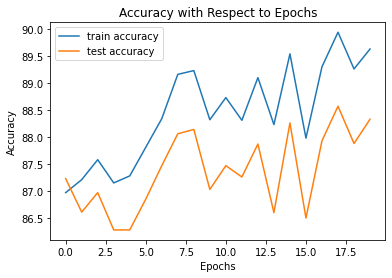

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)
acc0 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=20,hidden_layer=0,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
1 Loss: 0.8794070759185777
2 Loss: 0.6090871331121996
3 Loss: 0.5198482776971707
4 Loss: 0.3704656944704205
5 Loss: 0.3468190771047456
6 Loss: 0.3538626316627322
7 Loss: 0.312626450034084
8 Loss: 0.2113257206125608
9 Loss: 0.1872230049885901
10 Loss: 0.173208478048736
11 Loss: 0.16460847748083915
12 Loss: 0.17838613950094326
13 Loss: 0.16936193852614698
14 Loss: 0.16686956515412782
15 Loss: 0.16194524285879922
16 Loss: 0.1544235305712891
17 Loss: 0.1610767125443479
18 Loss: 0.1421718663397407
19 Loss: 0.14951392204804076
20 Loss: 0.1527305278301667
21 Loss: 0.1583453454485529
22 Loss: 0.1625572828582367
23 Loss: 0.15747753644865237
24 Loss: 0.13929020815250523
25 Loss: 0.12900637475469107
26 Loss: 0.13844172040284386
27 Loss: 0.14381789500746536
28 Loss: 0.15326506614982865
29 Loss: 0.12898097582636303
30 Loss: 0.12841936612122218
31 Loss: 0.1348897092107455
32 Loss: 0.14413935798433766
33 Loss: 0.148129

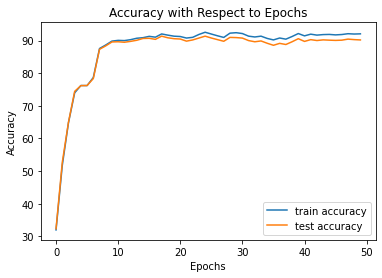

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)
acc1 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=50,hidden_layer=1,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.004,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
1 Loss: 0.2170039348896764
2 Loss: 0.18319993069421134
3 Loss: 0.15582421140898176
4 Loss: 0.15389505754196947
5 Loss: 0.1401091856156409
6 Loss: 0.13888766618531176
7 Loss: 0.1292572054355085
8 Loss: 0.12734243003953566
9 Loss: 0.1281839895160967
10 Loss: 0.13049270495083337
11 Loss: 0.13333117110606152
12 Loss: 0.13380516707328818
13 Loss: 0.13209773194668903
14 Loss: 0.13012325051914153
15 Loss: 0.12707464278519315
16 Loss: 0.12375733720927955
17 Loss: 0.12188409332311365
18 Loss: 0.11972024873878541
19 Loss: 0.11902326545780499
20 Loss: 0.11921008144131776
21 Loss: 0.11812612983431346
22 Loss: 0.11722299203355618
23 Loss: 0.11571099223139561
24 Loss: 0.11417551501554783
25 Loss: 0.11326448910184904
26 Loss: 0.11226815034621303
27 Loss: 0.11128574638728904
28 Loss: 0.11029384566733196
29 Loss: 0.10952072383560175
30 Loss: 0.10901528832021189
31 Loss: 0.1083830618896666
32 Loss: 0.10803222977372054
33 

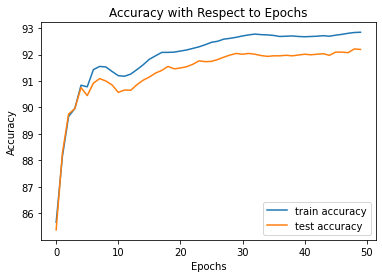

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)
acc2 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=50,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.9,graph=True)

**Experiment #2: Activation Function**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.19355413029430513
10 Loss: 0.18777306621380424
15 Loss: 0.17838261694147153
20 Loss: 0.1645377976700827
25 Loss: 0.18663023537406007
30 Loss: 0.15087050414808095
35 Loss: 0.15236389108286236
40 Loss: 0.15294973177758503
Accuracy: 89.21%
5 Loss: 0.1974453829747737
10 Loss: 0.19646115644146006
15 Loss: 0.15094570514547181
20 Loss: 0.15085072542828137
25 Loss: 0.13231642125185095
30 Loss: 0.13942094375563888
35 Loss: 0.16476216438543434
40 Loss: 0.15110210029610288
Accuracy: 91.33%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in exp


5 Loss: 0.6183402002081108
10 Loss: 0.5237555134502269
15 Loss: 0.46887021832586917
20 Loss: 0.4399776929125486
25 Loss: 0.42274405707515145
30 Loss: 0.41052034691615374
35 Loss: 0.4008545038615079
40 Loss: 0.3927952240720909
Accuracy: 75.07%
5 Loss: 0.18918183317512494
10 Loss: 0.17385276487433804
15 Loss: 0.16956142230232296
20 Loss: 0.16612626486690327
25 Loss: 0.16332361054766434
30 Loss: 0.16117183029887316
35 Loss: 0.15897510495113926
40 Loss: 0.15745543923471125
Accuracy: 89.73%


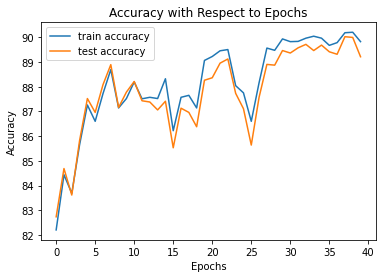

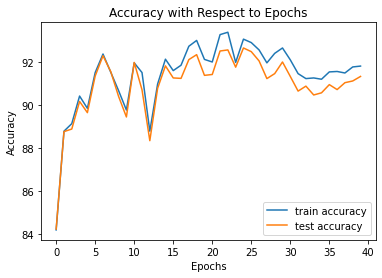

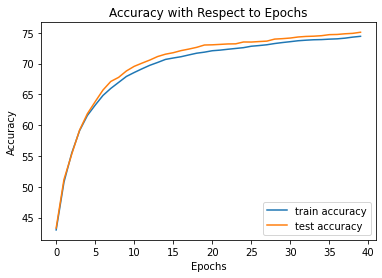

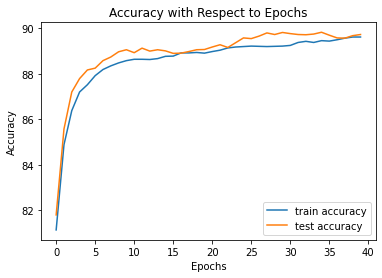

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_relu = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_leaky_relu = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=leaky_relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_sigmoid = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=sigmoid,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_tanh = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=tanh,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

**Experiment #3: No/L1/L2 Regularization**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.2472402815834028
10 Loss: 0.21654693806007558
15 Loss: 0.18561519566945575
20 Loss: 0.1708106231287834
25 Loss: 0.16451280855567627
30 Loss: 0.16055541041771024
35 Loss: 0.1574440981419021
40 Loss: 0.15520848716600516
Accuracy: 89.26%
5 Loss: 0.2642113443202208
10 Loss: 0.23479310167577733
15 Loss: 0.2459185907413186
20 Loss: 0.33739013242810967
25 Loss: 0.37957715184552937
30 Loss: 0.3469292497092712
35 Loss: 0.35009410370429517
40 Loss: 0.3604297753736074
Accuracy: 75.1%
5 Loss: 0.20519791127567996
10 Loss: 0.1749050802939413
15 Loss: 0.16928139195801908
20 Loss: 0.16219536661760392
25 Loss: 0.15151943333234313
30 Loss: 0.14432301961336147
35 Loss: 0.1393164965996302
40 Loss: 0.13561995545687272
Accuracy: 90.61%


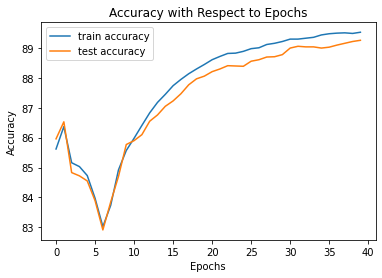

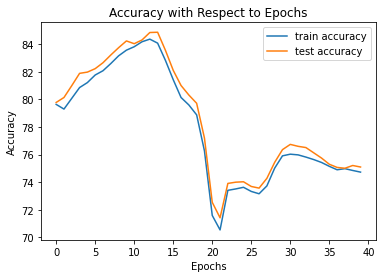

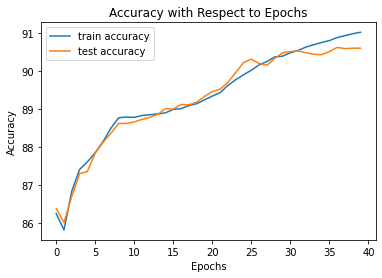

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_none = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_l1 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.1,elasticity=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_l2 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.1,elasticity=1.0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

**Experiment #4: Unnormalized Images**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.23509405332871144
10 Loss: 0.2023219413098544
15 Loss: 0.17365101288367749
20 Loss: 0.1656635649391367
25 Loss: 0.16265421743865882
30 Loss: 0.15968534290481062
35 Loss: 0.1582522905483278
40 Loss: 0.1558452075825355
Accuracy: 88.92%
x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.23642075222261968
10 Loss: 0.18615200397070805
15 Loss: 0.17577346761718848
20 Loss: 0.16975332518415848
25 Loss: 0.16653730207549644
30 Loss: 0.1628325897477896
35 Loss: 0.15823868782161848
40 Loss: 0.15532390365836002
Accuracy: 89.42%


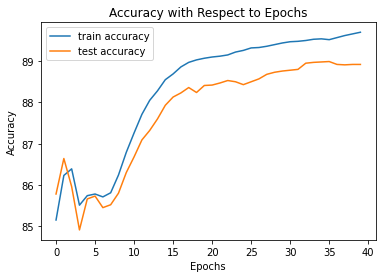

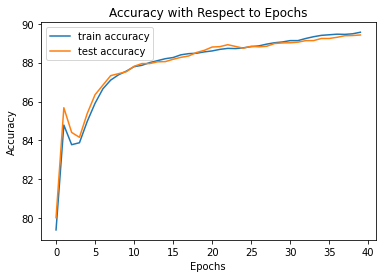

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)
acc_normalized = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.52,graph=True)

x_train_notnormalized, y_train, x_test_notnormalized, y_test = pre_process(raw_data, 60000, verbose=True, normalized=False)
acc_unnormalized = eval_acc(x_train_notnormalized,y_train,x_test_notnormalized,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

## Additional Experiments

**Additional Experiment #1: Number of Training Data Points**

x_train: : (150, 784)
y_train: (150, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.6673174370017998
10 Loss: 0.29621561266914115
15 Loss: 0.085742339476876
20 Loss: 0.00038378123864080794
25 Loss: 3.3639384983334526e-05
30 Loss: 1.7356382131881227e-05
35 Loss: 1.2730016168198902e-05
40 Loss: 1.1952345984643625e-05
Accuracy: 53.58%
x_train: : (1500, 784)
y_train: (1500, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.32423045030402986
10 Loss: 0.21436212407703817
15 Loss: 0.2057905772129053
20 Loss: 0.1591619406057569
25 Loss: 0.15067128946197708
30 Loss: 0.16077261508323662
35 Loss: 0.11876078066546059
40 Loss: 0.09045710337984861
Accuracy: 82.55%
x_train: : (15000, 784)
y_train: (15000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.2219565615407512
10 Loss: 0.19109413254582375
15 Loss: 0.14612930939219124
20 Loss: 0.1888066147463886
25 Loss: 0.13190630536101336
30 Loss: 0.14399574350086172
35 Loss: 0.12189867286874251
40 Loss: 0.1348864697233904
Accuracy: 89.76%
x_trai

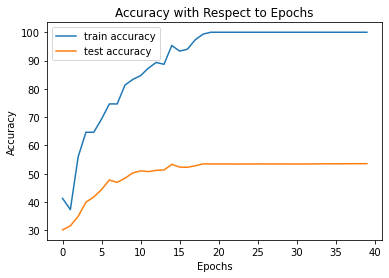

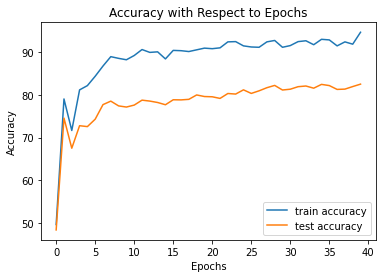

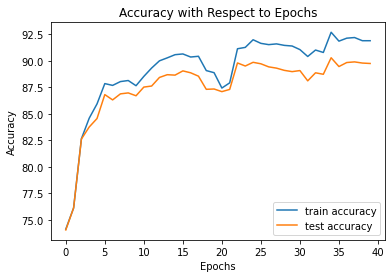

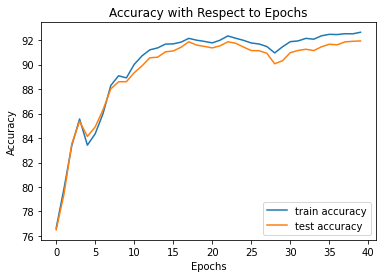

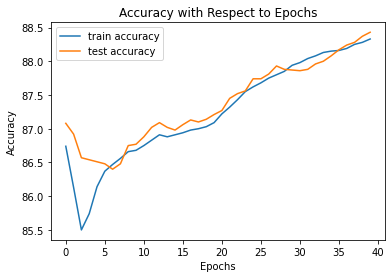

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 150, verbose=True)
acc_150 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train, y_train, x_test, y_test = pre_process(raw_data, 1500, verbose=True)
acc_1500 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train, y_train, x_test, y_test = pre_process(raw_data, 15000, verbose=True)
acc_15000 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train, y_train, x_test, y_test = pre_process(raw_data, 45000, verbose=True)
acc_45000 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)
acc_60000 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

**Additional Experiment #2: Simulated Annealing Power**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.240351607197459
10 Loss: 0.17987399406422763
15 Loss: 0.1752134077240104
20 Loss: 0.1912946188715257
25 Loss: 0.1837202468296708
30 Loss: 0.19303606426047865
35 Loss: 0.22138311240073424
40 Loss: 0.16508333155426894
Accuracy: 89.35%
5 Loss: 0.20616141167757857
10 Loss: 0.17954915857688905
15 Loss: 0.2003186366418018
20 Loss: 0.15295836968565332
25 Loss: 0.1432152382106719
30 Loss: 0.14546123351046183
35 Loss: 0.14215337138829148
40 Loss: 0.15706795731878095
Accuracy: 89.84%
5 Loss: 0.2128037334006655
10 Loss: 0.1685740158662002
15 Loss: 0.14909391013682416
20 Loss: 0.14399939984370572
25 Loss: 0.13514716703598653
30 Loss: 0.14194490867352594
35 Loss: 0.14074926214514819
40 Loss: 0.15340818463566275
Accuracy: 90.37%
5 Loss: 0.21316790247232542
10 Loss: 0.17385268356352024
15 Loss: 0.1487970781448956
20 Loss: 0.13947141678169406
25 Loss: 0.13847490640721538
30 Loss: 0.14171274528024994
35 Loss: 0

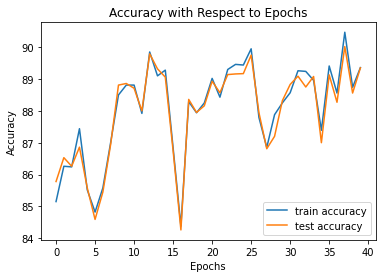

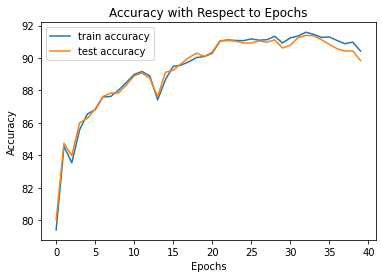

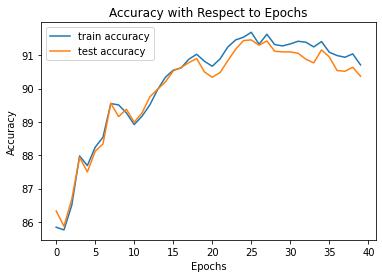

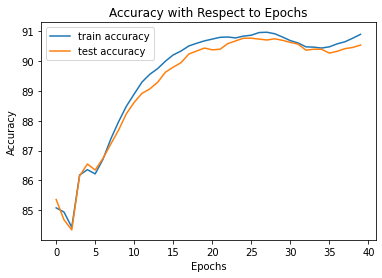

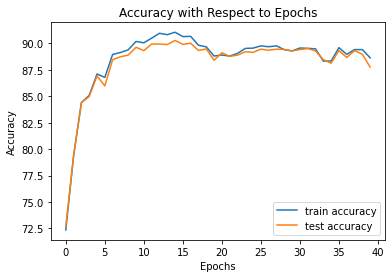

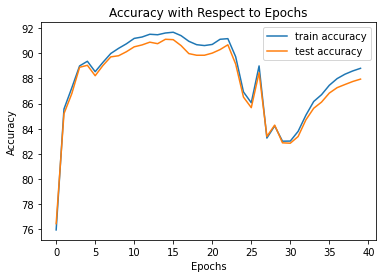

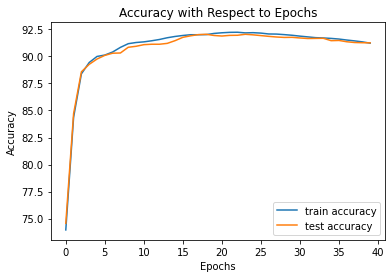

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_001 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.01,graph=True)
acc_005 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.05,graph=True)
acc_01 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.1,graph=True)
acc_025 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.25,graph=True)
acc_05 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_075 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.75,graph=True)
acc_1 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=1.0,graph=True)

**Additional Experiment #3: Momentum**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.15212683104046568
10 Loss: 0.22614438639286089
15 Loss: 0.1607217107429068
20 Loss: 0.13691429926713322
25 Loss: 0.13294618212346918
30 Loss: 0.2168340357269302
35 Loss: 0.13548052769594024
40 Loss: 0.15819508823103454
Accuracy: 89.66%
5 Loss: 0.1419102672921025
10 Loss: 0.1195834391724866
15 Loss: 0.11847373074044648
20 Loss: 0.11542443054397103
25 Loss: 0.1205426154655483
30 Loss: 0.1307571736840429
35 Loss: 0.1359536541371706
40 Loss: 0.11603094428343655
Accuracy: 92.5%
5 Loss: 0.15775661595292687
10 Loss: 0.18016645094774714
15 Loss: 0.20097187678454378
20 Loss: 0.24603788603804908
25 Loss: 0.19183888745845384
30 Loss: 0.1612473910877543
35 Loss: 0.15212383292817583
40 Loss: 0.1379445159948507
Accuracy: 90.82%
5 Loss: 0.13469617874020637
10 Loss: 0.17168503029346505
15 Loss: 0.17377552521595435
20 Loss: 0.16710802054570506
25 Loss: 0.13984463902397343
30 Loss: 0.1303776119062468
35 Loss: 0.

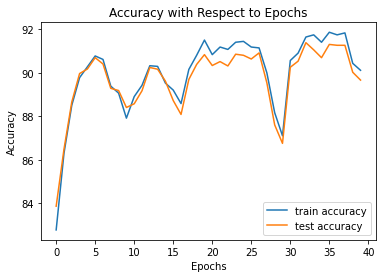

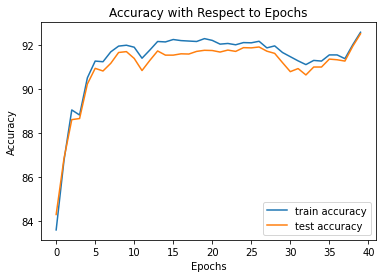

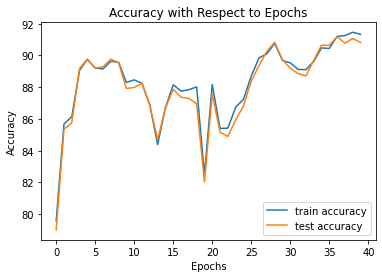

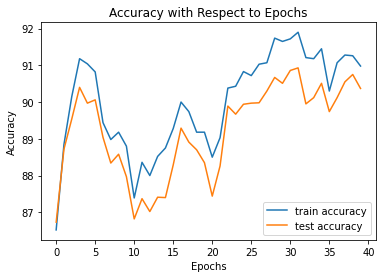

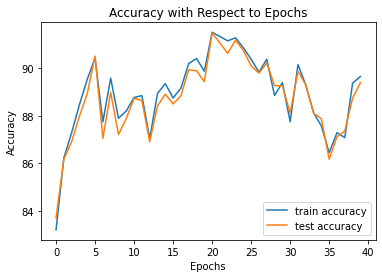

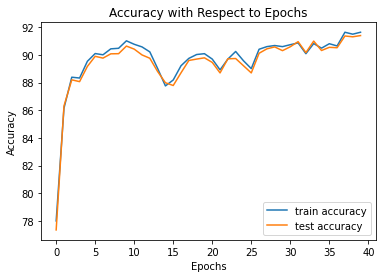

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_05 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,momentum=0.5,graph=True)
acc_08 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,momentum=0.8,graph=True)
acc_085 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,momentum=0.85,graph=True)
acc_09 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,momentum=0.9,graph=True)
acc_095 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,momentum=0.95,graph=True)
acc_099 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,momentum=0.99,graph=True)

**Additional Experiment #4: Batch Size**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.17633025425787213
10 Loss: 0.17614595524777002
15 Loss: 0.1251521932655696
20 Loss: 0.11600644041375129
25 Loss: 0.13299290057154695
30 Loss: 0.11927455649757883
35 Loss: 0.10897423909308407
40 Loss: 0.12795898149255266
Accuracy: 90.79%
5 Loss: 0.22248977587968824
10 Loss: 0.20240934924969037
15 Loss: 0.1840545675450274
20 Loss: 0.17651455611774577
25 Loss: 0.1729812787618251
30 Loss: 0.16924317417272994
35 Loss: 0.16557209522194932
40 Loss: 0.16111238261416536
45 Loss: 0.15522084475661213
50 Loss: 0.15128726535868312
55 Loss: 0.1486750949336541
60 Loss: 0.14609195664548677
65 Loss: 0.14326237536915618
70 Loss: 0.1407285169744552
75 Loss: 0.13924870894623242
80 Loss: 0.13933476497679978
85 Loss: 0.1399817364167995
90 Loss: 0.1410272886827122
95 Loss: 0.14181305188287566
100 Loss: 0.14200850060822479
105 Loss: 0.14147345047106583
110 Loss: 0.139074175574728
115 Loss: 0.1362365034326492
120 Loss:

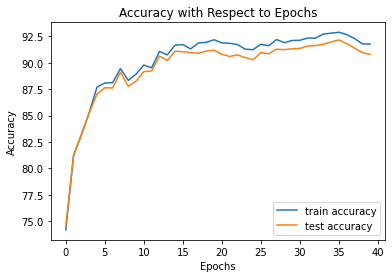

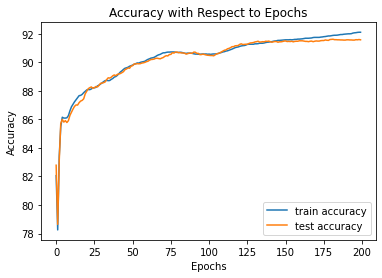

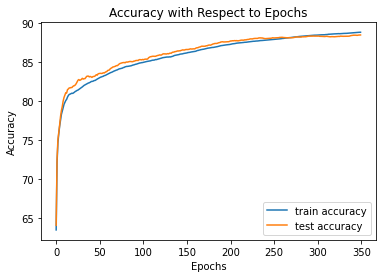

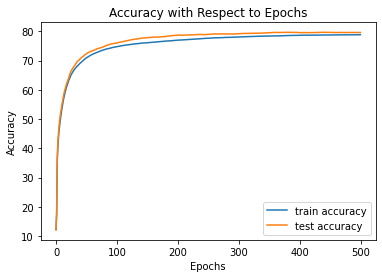

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_10 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_100 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=200,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=100,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_1000 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=350,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=1000,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_10000 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=500,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10000,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

**Additional Experiment #5: Network Width**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 1.6384829276140245
10 Loss: 1.6384829276140245
15 Loss: 1.6384829276140245
20 Loss: 1.6384829276140245
25 Loss: 1.6384829276140245
30 Loss: 1.6384829276140245
35 Loss: 1.6384829276140245
40 Loss: 1.6384829276140245
Accuracy: 9.58%
5 Loss: 0.6236343689581609
10 Loss: 0.6505685327162679
15 Loss: 0.6814527962405629
20 Loss: 0.6816650353708635
25 Loss: 0.6814338376958093
30 Loss: 0.6787801993074358
35 Loss: 0.6796169537446293
40 Loss: 0.7666120471380283
Accuracy: 40.51%
5 Loss: 0.5936267890708319
10 Loss: 0.5466260724218235
15 Loss: 0.5282661022292746
20 Loss: 0.5441927587776529
25 Loss: 0.5505545792654095
30 Loss: 0.4683544028939331
35 Loss: 0.41231969520878464
40 Loss: 0.39987847208176835
Accuracy: 72.8%
5 Loss: 0.33353283897549835
10 Loss: 0.2858070024557109
15 Loss: 0.2657204478848462
20 Loss: 0.257421249502358
25 Loss: 0.24812280344037124
30 Loss: 0.23938961716196408
35 Loss: 0.23295371308303295

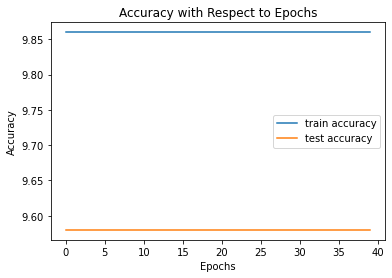

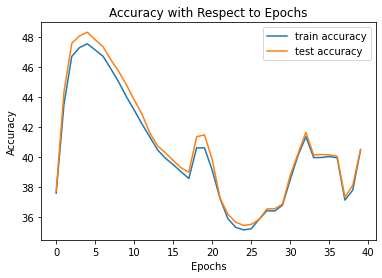

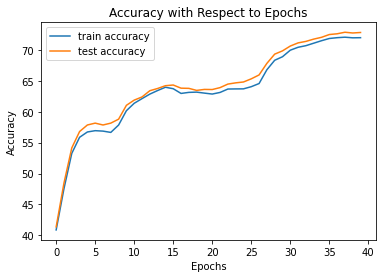

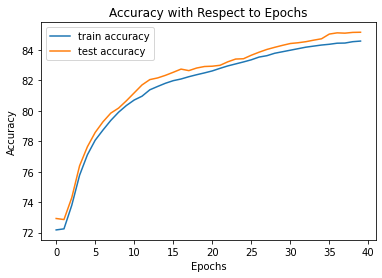

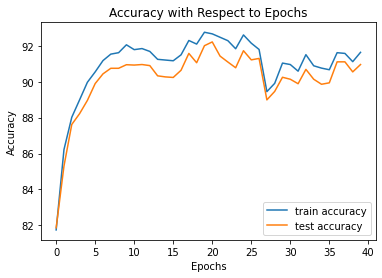

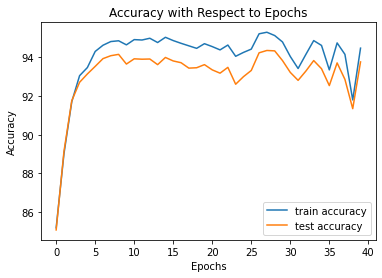

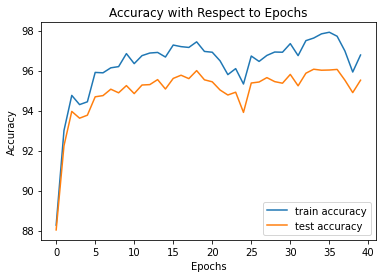

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_8 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=8,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.01,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_16 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=16,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_32 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=32,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_64 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=64,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_128 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_256 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=256,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_512 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=512,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

**Additional Experiment #6: Lambda (via L2 Regularization)**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.12949697698916204
10 Loss: 0.15534594694217052
15 Loss: 0.10867210725141387
20 Loss: 0.10351439736136796
25 Loss: 0.09520411877433452
30 Loss: 0.09493877153372933
35 Loss: 0.09432501566687906
40 Loss: 0.09151643120302491
Accuracy: 93.6%
5 Loss: 0.1602913152397445
10 Loss: 0.1317564591135802
15 Loss: 0.09022967553198433
20 Loss: 0.080447946102389
25 Loss: 0.07729331266625869
30 Loss: 0.08277629846037803
35 Loss: 0.07412363454493441
40 Loss: 0.07132170018403079
Accuracy: 94.38%
5 Loss: 0.1296905465112892
10 Loss: 0.09724027058034414
15 Loss: 0.08410216221471474
20 Loss: 0.069884814555993
25 Loss: 0.06748642266111236
30 Loss: 0.06486362379838115
35 Loss: 0.0674221260329659
40 Loss: 0.07500259633769021
Accuracy: 94.31%
5 Loss: 0.14309786666217522
10 Loss: 0.07668282735205133
15 Loss: 0.09533744623733886
20 Loss: 0.0695497717829006
25 Loss: 0.06040903014125078
30 Loss: 0.06108603465654099
35 Loss: 0

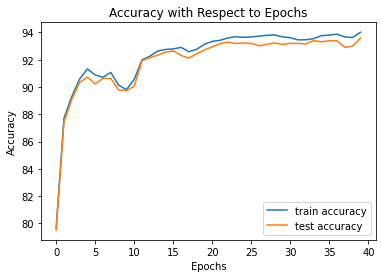

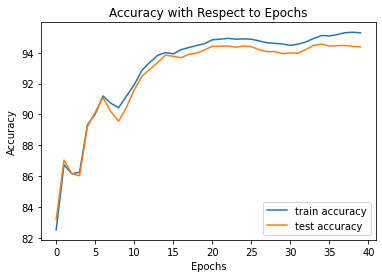

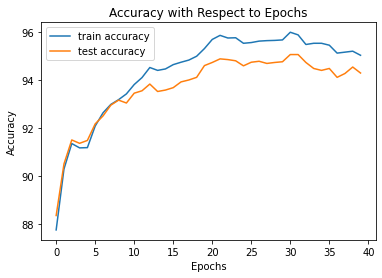

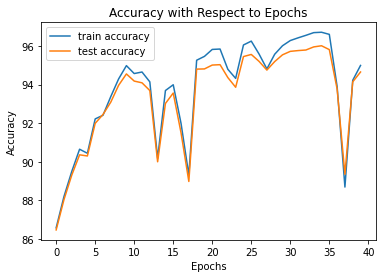

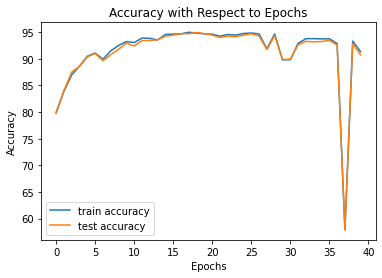

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True)

acc_01 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.1,elasticity=1.0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_025 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.25,elasticity=1.0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_05 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.5,elasticity=1.0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_075 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.75,elasticity=1.0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)
acc_09 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=40,hidden_layer=2,function=relu,verbose=True,regularize=0.9,elasticity=1.0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

**Experiment #7: Normalization and Standardization**

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
1 Loss: 0.27875446728613146
2 Loss: 0.24916968577732124
3 Loss: 0.2270106803994957
4 Loss: 0.2326174406890152
5 Loss: 0.2433804675818894
6 Loss: 0.24000874732044888
7 Loss: 0.24411292132342957
8 Loss: 0.22973720948966994
9 Loss: 0.21270815695972478
10 Loss: 0.19911489659052242
11 Loss: 0.188849899287013
12 Loss: 0.18382793030007558
13 Loss: 0.18329592172590123
14 Loss: 0.18049336000007699
15 Loss: 0.178202069015247
16 Loss: 0.17836176168982376
17 Loss: 0.17831438077351852
18 Loss: 0.17727538937710835
19 Loss: 0.1755402015104446
20 Loss: 0.1737333283827693
21 Loss: 0.17221367655634479
22 Loss: 0.17141162596986756
23 Loss: 0.16955313279089634
24 Loss: 0.1668831542401805
25 Loss: 0.16546347953798768
26 Loss: 0.16474578077201008
27 Loss: 0.1649131183738085
28 Loss: 0.16490999689984068
29 Loss: 0.16426920135924836
30 Loss: 0.16374074987991202
31 Loss: 0.16386565322974805
32 Loss: 0.16454842749197468
33 Loss: 

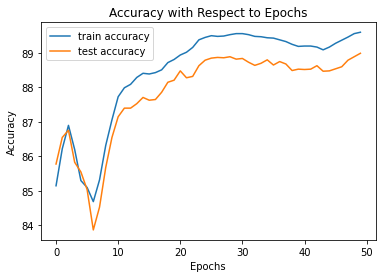

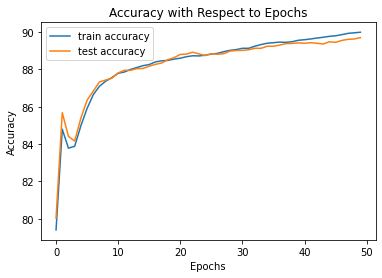

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True,normalized=True,standardized=False)
acc2 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=50,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True,normalized=False,standardized=True)
acc2 = eval_acc(x_train,y_train,x_test,y_test,model=MLP_sgd,M=128,add_bias=True,epochs=50,hidden_layer=2,function=relu,verbose=True,regularize=0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=True)

## Bagging Experiments

**Bagging Experiment #1 (ReLU, Learning Rate of 0.001)**

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 45000, verbose=True, normalized=True, standardized=False)
y_pred = bagging(x_train,y_train,x_test,y_test,model=MLP_sgd,M=512,add_bias=True,epochs=30,hidden_layer=2,function=relu,
               verbose=True,regularize=0.75,elasticity=1.0,batch_size=10,alpha=0.001,sim_anneal=True,sim_anneal_pow=0.5,graph=False, runs=5)

x_train: : (45000, 784)
y_train: (45000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.07679110032864088
10 Loss: 0.05521146837826593
15 Loss: 0.0490158784341097
20 Loss: 0.04537322441425352
25 Loss: 0.050981596002509275
30 Loss: 0.041899917999103524
96.35
5 Loss: 0.064277451606316
10 Loss: 0.04868694341414342
15 Loss: 0.057731424382381526
20 Loss: 0.05901219547331334
25 Loss: 0.05041686474723106
30 Loss: 0.04775396571789971
95.79
5 Loss: 0.06618704944806028
10 Loss: 0.055319858017452095
15 Loss: 0.05537146240584164
20 Loss: 0.06173885496557562
25 Loss: 0.037378144446144804
30 Loss: 0.05152756355897542
95.6
5 Loss: 0.06894849938496314
10 Loss: 0.05423743891236023
15 Loss: 0.05537408745988223
20 Loss: 0.0713499205300813
25 Loss: 0.042691890735864164
30 Loss: 0.03576827148872278
96.65
5 Loss: 0.06811161221949033
10 Loss: 0.05812442541638024
15 Loss: 0.0609767255882284
20 Loss: 0.04560153926726816
25 Loss: 0.10127593074211208
30 Loss: 0.04616824206239042
95.88
[96.35, 95.79, 95.6, 9

**Bagging Experiment #2 (ReLU, Learning Rate of 0.0001)**

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 45000, verbose=True, normalized=True, standardized=False)
y_pred = bagging(x_train,y_train,x_test,y_test,model=MLP_sgd,M=512,add_bias=True,epochs=30,hidden_layer=2,function=relu,
               verbose=True,regularize=0.75,elasticity=1.0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=False, runs=5)

x_train: : (45000, 784)
y_train: (45000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.11726311563714484
10 Loss: 0.0861991217762184
15 Loss: 0.07354514330459706
20 Loss: 0.06301989349248656
25 Loss: 0.05444666107300406
30 Loss: 0.048250569516890635
94.8
5 Loss: 0.11755568689384584
10 Loss: 0.0868720289756379
15 Loss: 0.0735682011761272
20 Loss: 0.06443159388171403
25 Loss: 0.05779472290109064
30 Loss: 0.053128960283143394
94.62
5 Loss: 0.13219236981331736
10 Loss: 0.09902097709099443
15 Loss: 0.08086719584032398
20 Loss: 0.06787427216769364
25 Loss: 0.05966951369894937
30 Loss: 0.05397299605161179
94.78
5 Loss: 0.1212509649742832
10 Loss: 0.08980992977246145
15 Loss: 0.07239467037143259
20 Loss: 0.06506011147235735
25 Loss: 0.05905797203858618
30 Loss: 0.05445246924631734
94.65
5 Loss: 0.11967357392644294
10 Loss: 0.08446496413414728
15 Loss: 0.07144472400640552
20 Loss: 0.06170408351232745
25 Loss: 0.054985831180580126
30 Loss: 0.05042523758796073
94.7
[94.8, 94.62, 94.78, 94.6

**Bagging Experiment #3 (Leaky ReLU, Learning Rate of 0.0001)**

In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 45000, verbose=True, normalized=True, standardized=False)
y_pred = bagging(x_train,y_train,x_test,y_test,model=MLP_sgd,M=512,add_bias=True,epochs=30,hidden_layer=2,function=leaky_relu,
               verbose=True,regularize=0.75,elasticity=1.0,batch_size=10,alpha=0.0001,sim_anneal=True,sim_anneal_pow=0.5,graph=False, runs=5)

x_train: : (45000, 784)
y_train: (45000, 10)
x_test: (10000, 784)
y_test: (10000,)
5 Loss: 0.08875557138763476
10 Loss: 0.059631394472830015
15 Loss: 0.04941445103385803
20 Loss: 0.04124501564229773
25 Loss: 0.03483666298305662
30 Loss: 0.030244382169214733
94.79
5 Loss: 0.08724923106794612
10 Loss: 0.0664297497272588
15 Loss: 0.050443272102260794
20 Loss: 0.04239331375080288
25 Loss: 0.03703230276790152
30 Loss: 0.03246151501827571
94.97
5 Loss: 0.11181759143016544
10 Loss: 0.06774951255297885
15 Loss: 0.055612860189620174
20 Loss: 0.044632569114285724
25 Loss: 0.03796300968347575
30 Loss: 0.03357009747719068
95.42
5 Loss: 0.08518276849513363
10 Loss: 0.055808730869917285
15 Loss: 0.0435279903153075
20 Loss: 0.03524584260644791
25 Loss: 0.0302007776955649
30 Loss: 0.026686571212710054
95.22
5 Loss: 0.08258856288706291
10 Loss: 0.05997616500818191
15 Loss: 0.047534673963503166
20 Loss: 0.03929503369808996
25 Loss: 0.0342272103846103
30 Loss: 0.030695305338853025
95.27
[94.79, 94.97, 95

## Globally Optimized Experiments

x_train: : (60000, 784)
y_train: (60000, 10)
x_test: (10000, 784)
y_test: (10000,)
1 Loss: 0.13434615117290924
2 Loss: 0.10283520079950538
3 Loss: 0.08144693909110251
4 Loss: 0.06461807046258035
5 Loss: 0.05285093847490318
6 Loss: 0.044530697033137265
7 Loss: 0.04106871700831289
8 Loss: 0.03711626110822593
9 Loss: 0.03360975910134647
10 Loss: 0.031016576489681643
11 Loss: 0.028991864105421535
12 Loss: 0.027445388559470773
13 Loss: 0.026179418229948036
14 Loss: 0.025177482353993533
15 Loss: 0.02445179566964548
16 Loss: 0.0238982118881801
17 Loss: 0.02348783918059802
18 Loss: 0.023176642396327374
19 Loss: 0.022947759175549823
20 Loss: 0.022796552684409613
96.9


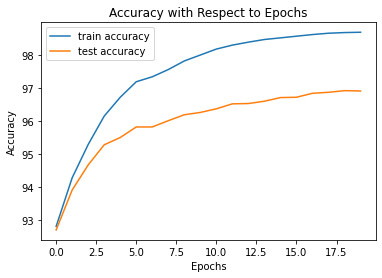

1 Loss: 0.1907270936448101
2 Loss: 0.17314374683099512
3 Loss: 0.2089679642259291
4 Loss: 0.28079362387690077
5 Loss: 0.14731360538751423
6 Loss: 0.11478456427095496
7 Loss: 0.08432901945238208
8 Loss: 0.08425612734748726
9 Loss: 0.07813207295441783
10 Loss: 0.06854262346577397
11 Loss: 0.0701080001395596
12 Loss: 0.061272820981497444
13 Loss: 0.057687379153003
14 Loss: 0.04916654708702439
15 Loss: 0.046664200134240545
16 Loss: 0.04451454821908616
17 Loss: 0.04038906193595172
18 Loss: 0.040800636946610985
19 Loss: 0.039790709893020366
20 Loss: 0.036489009898184356
96.17


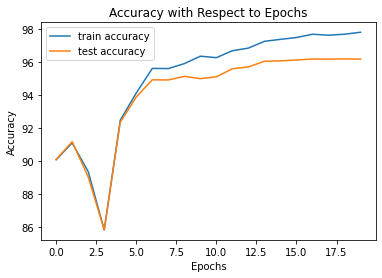

1 Loss: 0.14570750504763694
2 Loss: 0.10743091735527595
3 Loss: 0.07203018880882985
4 Loss: 0.062424492738795606
5 Loss: 0.052882259921010796
6 Loss: 0.04760222103162112
7 Loss: 0.04219008901855013
8 Loss: 0.03811131905569989
9 Loss: 0.03486957330335591
10 Loss: 0.03249990265729671
11 Loss: 0.030504823709105188
12 Loss: 0.028918089654256598
13 Loss: 0.027618452258498908
14 Loss: 0.02664186921929147
15 Loss: 0.02586372294496402
16 Loss: 0.025251844250797913
17 Loss: 0.02477697896958832
18 Loss: 0.024411167496686394
19 Loss: 0.024129523184597226
20 Loss: 0.023909517103996927
96.88


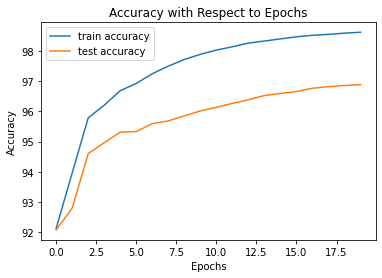

1 Loss: 0.16296777383466254
2 Loss: 0.116834760096788
3 Loss: 0.09023809621871376
4 Loss: 0.07936239305913186
5 Loss: 0.08621213646636305
6 Loss: 0.05960048585018595
7 Loss: 0.05511541999859127
8 Loss: 0.04926119928395257
9 Loss: 0.04267916484826973
10 Loss: 0.03954227929289549
11 Loss: 0.03579232954062455
12 Loss: 0.03281830646533368
13 Loss: 0.030489149425256244
14 Loss: 0.028728129252200425
15 Loss: 0.027272234504896024
16 Loss: 0.02604727335116344
17 Loss: 0.024984076095286314
18 Loss: 0.024223879061160927
19 Loss: 0.023597796464962476
20 Loss: 0.02302060779152914
96.91


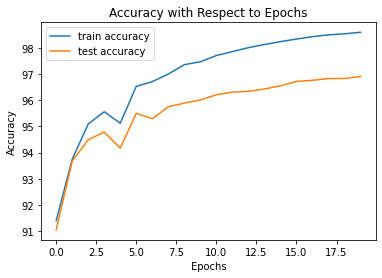

1 Loss: 0.1422724863784163
2 Loss: 0.09320717467887349
3 Loss: 0.08054622989486429
4 Loss: 0.06420072789214452
5 Loss: 0.05471679427342904
6 Loss: 0.04866647504426228
7 Loss: 0.04276516799715404
8 Loss: 0.038356097159733545
9 Loss: 0.034684391621252565
10 Loss: 0.03190733497102319
11 Loss: 0.029792807564834246
12 Loss: 0.028134411819140323
13 Loss: 0.02689612993019762
14 Loss: 0.025896180429008674
15 Loss: 0.025145718524513274
16 Loss: 0.024577442129386222
17 Loss: 0.02416098457375311
18 Loss: 0.02384951113403084
19 Loss: 0.023625364982011815
20 Loss: 0.02348479784937116
96.92


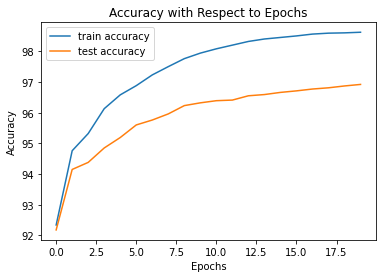

1 Loss: 0.13448805640986292
2 Loss: 0.09164163162627381
3 Loss: 0.07582397698146047
4 Loss: 0.06897013299175633
5 Loss: 0.0540754901187362
6 Loss: 0.04652305658358477
7 Loss: 0.04005466633135438
8 Loss: 0.036487920281542345
9 Loss: 0.03397329016007318
10 Loss: 0.03154690797829053
11 Loss: 0.029833509475710968
12 Loss: 0.028265765380897354
13 Loss: 0.02705106109858466
14 Loss: 0.02599911646269486
15 Loss: 0.025206068494409945
16 Loss: 0.02455461012342098
17 Loss: 0.024057433806190985
18 Loss: 0.02367496400231286
19 Loss: 0.02338979114654695
20 Loss: 0.023200508510169856
96.67


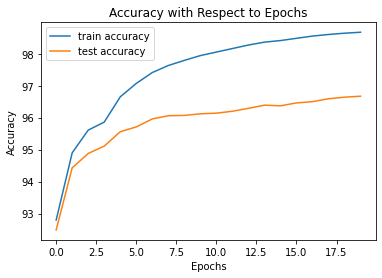

1 Loss: 0.13574046552403765
2 Loss: 0.10782699560919837
3 Loss: 0.0768497858420626
4 Loss: 0.06700230835170884
5 Loss: 0.05630395668502945
6 Loss: 0.05062560870680613
7 Loss: 0.0442535750299735
8 Loss: 0.039496130622197534
9 Loss: 0.03585148576216698
10 Loss: 0.03283638024015589
11 Loss: 0.030437983881442168
12 Loss: 0.028545465805691252
13 Loss: 0.027070058903494357
14 Loss: 0.025867979378168485
15 Loss: 0.024922815208567005
16 Loss: 0.024162769777249623
17 Loss: 0.023565447308867327
18 Loss: 0.02312903889307138
19 Loss: 0.022792173561919243
20 Loss: 0.022565155021581143
96.7


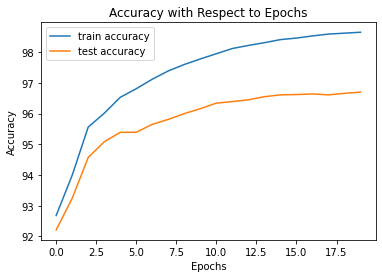

[96.9, 96.17, 96.88, 96.91, 96.92, 96.67, 96.7]
Accuracy: 97.91%


In [ ]:
x_train, y_train, x_test, y_test = pre_process(raw_data, 60000, verbose=True, normalized=False, standardized=True)
y_pred = bagging(x_train,y_train,x_test,y_test,model=MLP_sgd,M=512,add_bias=True,epochs=20,hidden_layer=2,function=leaky_relu,
               verbose=True,regularize=0.8,elasticity=1.0,batch_size=10,alpha=0.0002,sim_anneal=True,sim_anneal_pow=0.5,graph=True, runs=7)[0]

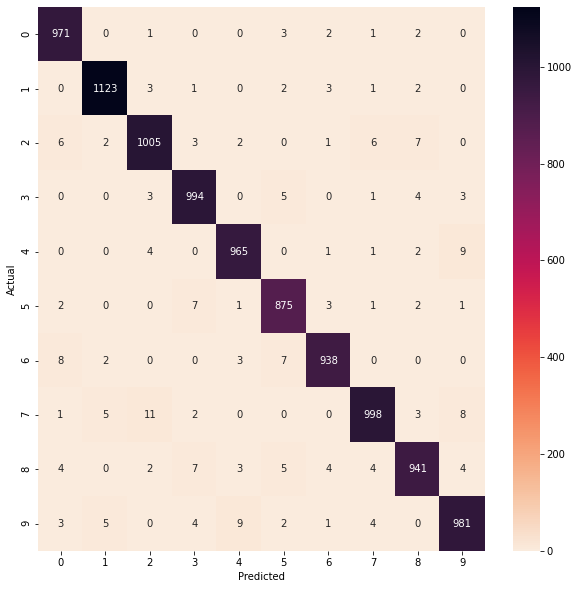

In [ ]:
import seaborn as sn
plt.figure(figsize=(10,10))
data = {'y_Actual': y_test,'y_Predicted': y_pred.mode[0]} #make dictionary
df = pds.DataFrame(data, columns=['y_Actual','y_Predicted']) #transform to dataframe
confusion_matrix = pds.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap="rocket_r")
plt.show()

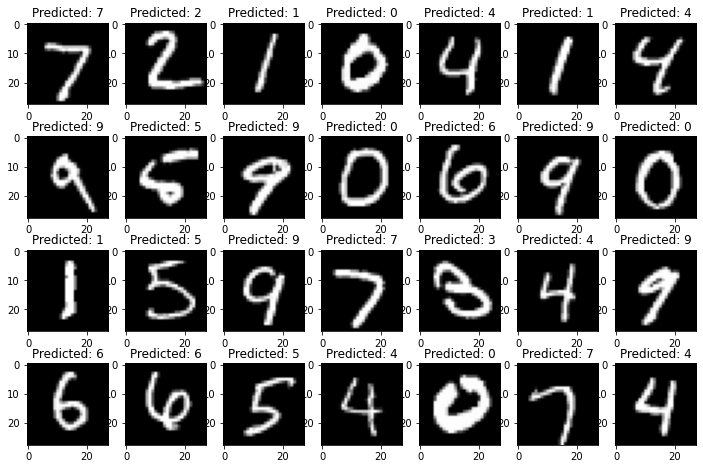

In [ ]:
visualizer(x_test, y_pred.mode[0], l=4, w = 7)